In [1]:
!cp -r /content/drive/MyDrive/Pose_Estimation_Paper/* /content/

In [2]:
!unzip -j /content/images.zip -d /content/images/ > /dev/null

In [3]:
!unzip -j /content/images2.zip -d /content/images2/ > /dev/null

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, DepthwiseConv2D, Conv2D, MaxPool2D, Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import MeanAbsoluteError

In [6]:
df = pd.read_pickle('dataset.zip')
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by  ...       pk20y        px        py         pz       pqw  \
0  240.004065  ...  258.898409  0.845582 -1.128232  57.647185  0.432849   
1  316.186593  ...  323.063989 -2.419494  3.715695  52.558606 -0.100566   
2  344.785139  ...  301.092395 -2.423551  5.274911  58.307099  0.037426   
3  255.793595  ...  217.657242 -2.546036 -0.923423  54.050802  0.682806   
4  257.882250  ...  271.752007  4.864291  0.234981  52.788851  0.814325   

        pqx       pqy       pqz        dr        dq  
0 -0.312149  0.835873 -0.128532  2.533527  0.075513  
1 -0.307319  0.270371  0.906830  3.090082  0.022440  
2  0.476215  0.861147 -0.173909  1.401429  0.081497  
3  0.292231 -0.326075  0.584852  0.742336  0.093440  
4 -0.494780 -0.300450 -0.042405  1.699849  0.062826  

[5 rows x 197 columns]

In [7]:
N = len(df)
W = 256
H = 256

images = np.zeros((N, H, W, 3), dtype=np.float32)
keypts = np.zeros((N, 21, 2), dtype=np.float32)

In [8]:
for i in tqdm(range(N)):
  img = cv2.imread('/content/images2/' + df.iloc[i]['Image'])
  img = cv2.resize(img, (W,H))
  
  images[i] = img
  keypts[i] = np.reshape(df.iloc[i]['ck0x':'ck20y'].values, (21,2))

images /= 255.0
keypts /= 512

100%|██████████| 1000/1000 [00:04<00:00, 225.40it/s]


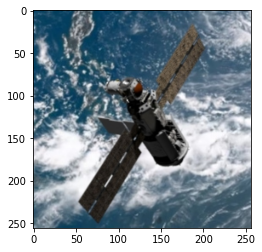

In [9]:
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, keypts, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 256, 256, 3) (800, 21, 2)
(200, 256, 256, 3) (200, 21, 2)


In [11]:
def build_model():

  model = Sequential([
      Input((256, 256, 3)),
      Conv2D(32, (3,3), activation='relu'),
      MaxPool2D(), # 128
      Conv2D(64, (3,3), activation='relu'),
      MaxPool2D(), # 64
      Conv2D(128, (3,3), activation='relu'),
      MaxPool2D(), # 32
      Conv2D(256, (3,3), activation='relu'),
      MaxPool2D(), # 16
      Conv2D(512, (3,3), activation='relu'),
      MaxPool2D(), # 8
      Conv2D(1024, (3,3), activation='relu'),
      MaxPool2D(), # 4
      Flatten(),
      Dense(729, activation='relu'),
      Dense(128, activation='relu'),
      Dense(42),
      Reshape((21,2))
  ])

  # i = Input((256,256,3))
  # x = Conv2D(32, (3,3), activation='relu')(i)
  # x = MaxPool2D()(x) # 128
  # x = Conv2D(64, (3,3), activation='relu')(x)
  # x = MaxPool2D()(x) # 64
  # x = Conv2D(128, (3,3), activation='relu')(x)
  # x = MaxPool2D()(x) # 32
  # x = Conv2D(256, (3,3), activation='relu')(x)
  # x = MaxPool2D()(x) # 16
  # x = Conv2D(512, (3,3), activation='relu')(x)
  # x = MaxPool2D()(x) # 8
  # x = Conv2D(1024, (3,3), activation='relu')(x)
  # x = Flatten()(x)
  # x = Dense(128, activation='relu')(x)
  # x = Dense(42)(x)
  # x = Reshape((21,2))(x)

  # model = Model(inputs=i, outputs=x)

  model.compile(optimizer='adam', loss='mae')

  return model

model = build_model()
display(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

None

In [13]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
7/7 [==============================] - 5s 788ms/step - loss: 0.4257 - val_loss: 0.3063
Epoch 2/100
7/7 [==============================] - 2s 320ms/step - loss: 0.2579 - val_loss: 0.2042
Epoch 3/100
7/7 [==============================] - 2s 327ms/step - loss: 0.1914 - val_loss: 0.1739
Epoch 4/100
7/7 [==============================] - 2s 357ms/step - loss: 0.1693 - val_loss: 0.1683
Epoch 5/100
7/7 [==============================] - 2s 341ms/step - loss: 0.1657 - val_loss: 0.1668
Epoch 6/100
7/7 [==============================] - 2s 338ms/step - loss: 0.1643 - val_loss: 0.1649
Epoch 7/100
7/7 [==============================] - 2s 333ms/step - loss: 0.1618 - val_loss: 0.1630
Epoch 8/100
7/7 [==============================] - 2s 320ms/step - loss: 0.1616 - val_loss: 0.1627
Epoch 9/100
7/7 [==============================] - 2s 321ms/step - loss: 0.1614 - val_loss: 0.1626
Epoch 10/100
7/7 [==============================] - 2s 334ms/step - loss: 0.1608 - val_loss: 0.1623
Epoch 11/

In [14]:
with open('keypt-history.txt', 'w') as f:
  f.write('loss\tval_loss\n')
  for i in range(len(history.epoch)):
    f.write(f"{history.history['loss'][i]}\t{history.history['val_loss'][i]}\n")

In [40]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='mae', optimizer=Adam(learning_rate=1e-5))

In [122]:
model.optimizer.learning_rate

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [13]:
pred_keypts_train = model.predict(X_train)
pred_keypts_test = model.predict(X_test)

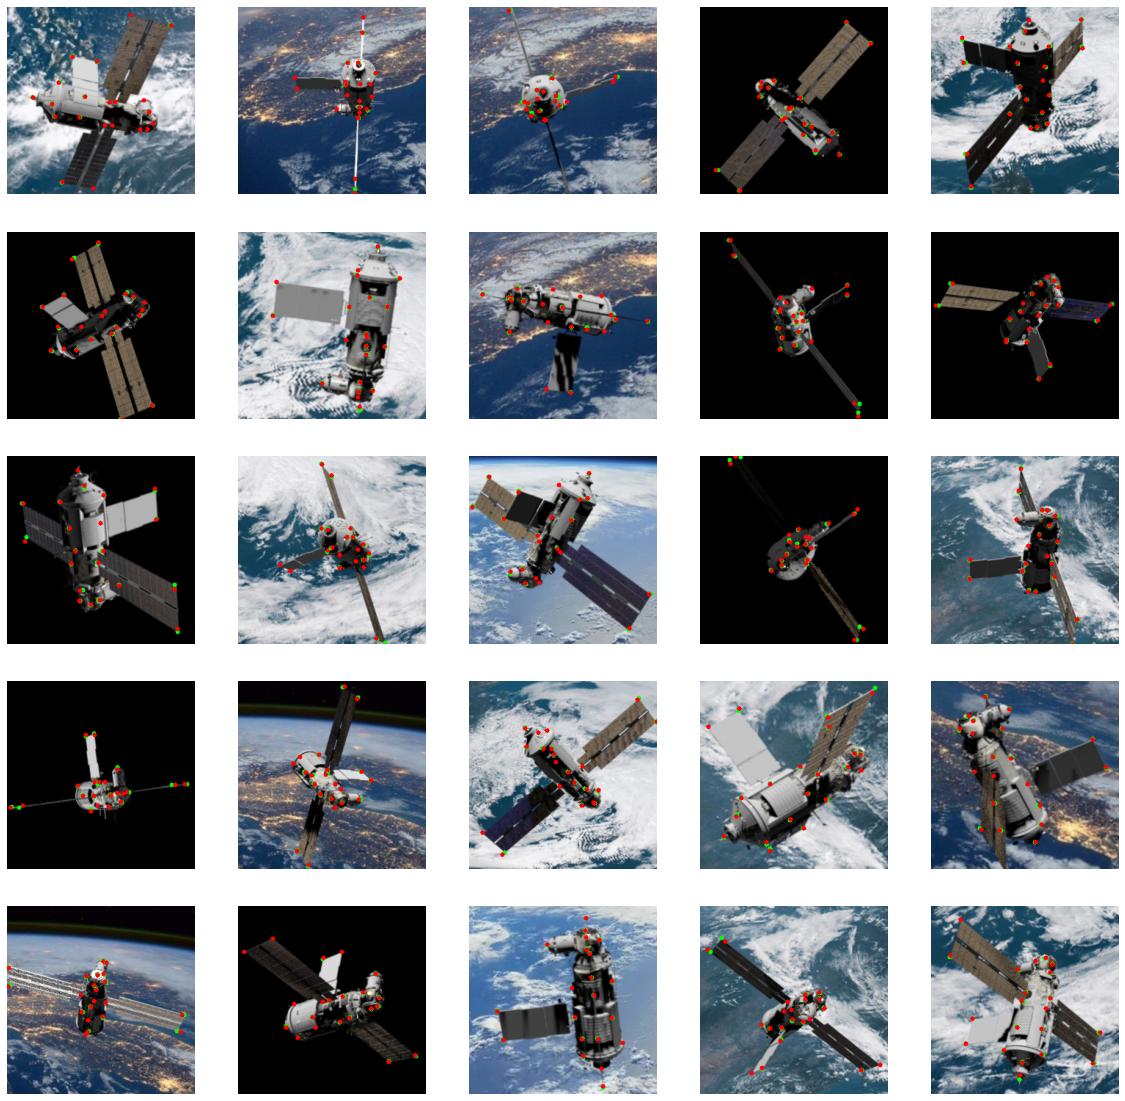

In [43]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(X_train), 25, replace=False)):
  img = X_train[v,:,:].copy()
  
  true_keypts = y_train[v]
  pred_keypts = pred_keypts_train[v]

  for j in range(21):
    img = cv2.circle(img, (int(true_keypts[j,0]*256), int(true_keypts[j,1]*256)), radius=3, color=(0, 1, 0), thickness=-1)
    img = cv2.circle(img, (int(pred_keypts[j,0]*256), int(pred_keypts[j,1]*256)), radius=3, color=(0, 0, 1), thickness=-1)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')

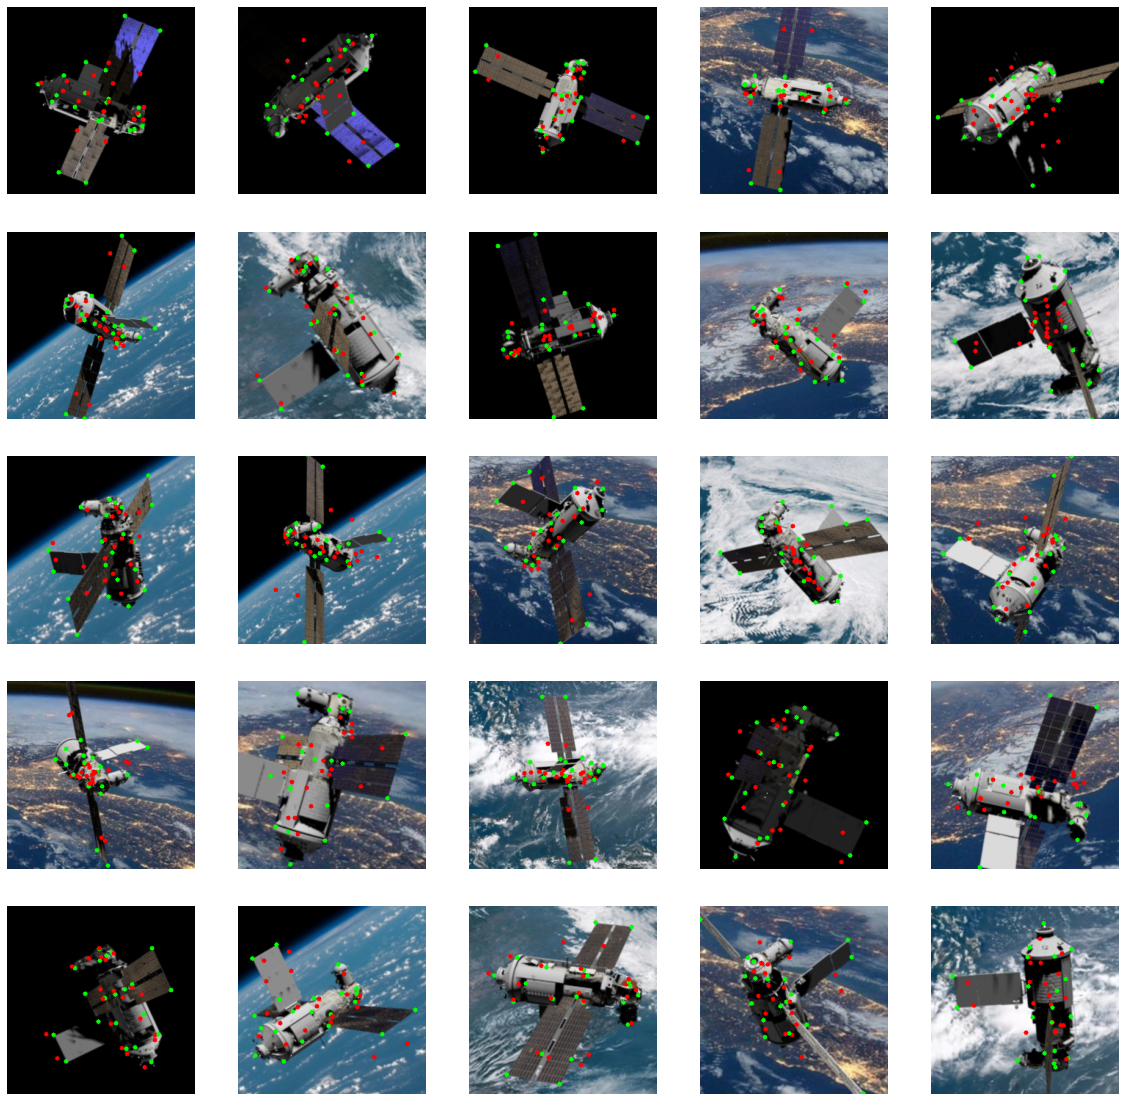

In [44]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(X_test), 25, replace=False)):
  img = X_test[v,:,:].copy()
  
  true_keypts = y_test[v]
  pred_keypts = pred_keypts_test[v]

  for j in range(21):
    img = cv2.circle(img, (int(true_keypts[j,0]*256), int(true_keypts[j,1]*256)), radius=3, color=(0, 1, 0), thickness=-1)
    img = cv2.circle(img, (int(pred_keypts[j,0]*256), int(pred_keypts[j,1]*256)), radius=3, color=(0, 0, 1), thickness=-1)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')

In [45]:
model.save('keypt-regress-model')

In [46]:
!du -sh keypt-regress-model

108M	keypt-regress-model


In [11]:
model = load_model('keypt-regress-model')

In [12]:
pred_keypts = model.predict(images)

In [13]:
sample_loss = MeanAbsoluteError('none')(keypts, pred_keypts).numpy()
sample_loss = np.mean(sample_loss, axis=1)

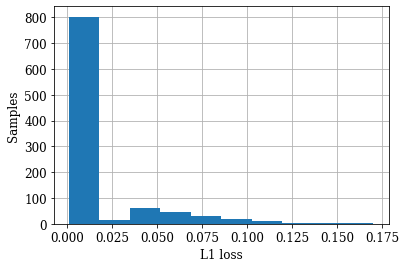

In [14]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(zorder=0)
plt.hist(sample_loss, zorder=3)
plt.xlabel('L1 loss')
plt.ylabel('Samples')
plt.savefig('keypt-regress-hist.eps', bbox_inches='tight')

In [14]:
MeanAbsoluteError('none')(y_train, pred_keypts_train).numpy().mean()

0.0026509478

In [15]:
MeanAbsoluteError('none')(y_test, pred_keypts_test).numpy().mean()

0.0664588

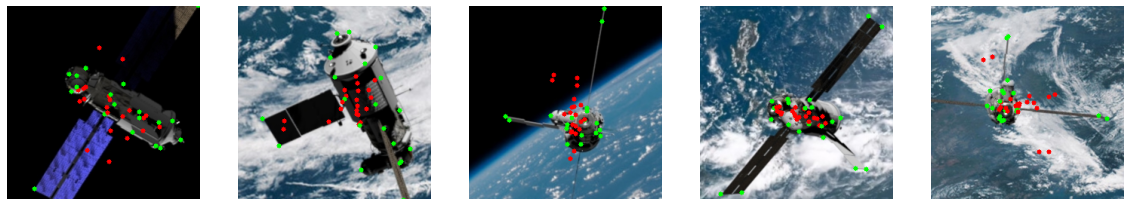

In [50]:
# plot images
fig, ax = plt.subplots(1,5, figsize=(20,4))

for i,v in enumerate(np.random.choice(np.where(sample_loss > 0.150)[0], 5, replace=False)):
  img = images[v,:,:].copy()
  
  true_keypt = keypts[v]
  pred_keypt = pred_keypts[v]

  for j in range(21):
    img = cv2.circle(img, (int(true_keypt[j,0]*256), int(true_keypt[j,1]*256)), radius=3, color=(0, 1, 0), thickness=-1)
    img = cv2.circle(img, (int(pred_keypt[j,0]*256), int(pred_keypt[j,1]*256)), radius=3, color=(0, 0, 1), thickness=-1)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  ax[i].imshow(img)
  ax[i].axis('off')
  
  plt.savefig('keypt-regress-bad-examples.jpg', bbox_inches='tight')

In [48]:
for i in range(21):
  df['pck'+str(i)+'x'] = pred_keypts[:,i,0]*512
  df['pck'+str(i)+'y'] = pred_keypts[:,i,1]*512

In [49]:
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by  ...       pk20y        px        py         pz       pqw  \
0  240.004065  ...  257.507283  0.845582 -1.128232  57.647185  0.432849   
1  316.186593  ...  319.205657 -2.419494  3.715695  52.558606 -0.100566   
2  344.785139  ...  299.782406 -2.423551  5.274911  58.307099  0.037426   
3  255.793595  ...  212.784811 -2.546036 -0.923423  54.050802  0.682806   
4  257.882250  ...  271.135352  4.864291  0.234981  52.788851  0.814325   

        pqx       pqy       pqz        dr        dq  
0 -0.312149  0.835873 -0.128532  2.533527  0.075513  
1 -0.307319  0.270371  0.906830  3.090082  0.022440  
2  0.476215  0.861147 -0.173909  1.401429  0.081497  
3  0.292231 -0.326075  0.584852  0.742336  0.093440  
4 -0.494780 -0.300450 -0.042405  1.699849  0.062826  

[5 rows x 197 columns]

In [50]:
df.to_pickle('dataset.zip')

In [51]:
!cp -r /content/keypt-regress-model /content/dataset.zip /content/drive/MyDrive/Pose_Estimation_Paper/

In [52]:
df = pd.read_pickle('dataset.zip')

In [53]:
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by  ...       pk20y        px        py         pz       pqw  \
0  240.004065  ...  257.507283  0.845582 -1.128232  57.647185  0.432849   
1  316.186593  ...  319.205657 -2.419494  3.715695  52.558606 -0.100566   
2  344.785139  ...  299.782406 -2.423551  5.274911  58.307099  0.037426   
3  255.793595  ...  212.784811 -2.546036 -0.923423  54.050802  0.682806   
4  257.882250  ...  271.135352  4.864291  0.234981  52.788851  0.814325   

        pqx       pqy       pqz        dr        dq  
0 -0.312149  0.835873 -0.128532  2.533527  0.075513  
1 -0.307319  0.270371  0.906830  3.090082  0.022440  
2  0.476215  0.861147 -0.173909  1.401429  0.081497  
3  0.292231 -0.326075  0.584852  0.742336  0.093440  
4 -0.494780 -0.300450 -0.042405  1.699849  0.062826  

[5 rows x 197 columns]

In [54]:
N = len(df)

uncrop_keypts = np.zeros((N,21,2))

for i in range(N):
  x = df.iloc[i]['ppbx']
  y = df.iloc[i]['ppby']
  b = df.iloc[i]['ppbw']

  crop_keypts = np.reshape(df.iloc[i]['pck0x':'pck20y'].values, (21,2))
  crop_keypts /= 512 
  crop_keypts *= b

  crop_keypts[:,0] += (x-b/2)
  crop_keypts[:,1] += (y-b/2)

  uncrop_keypts[i] = crop_keypts

for i in range(21):
  df['pk'+str(i)+'x'] = uncrop_keypts[:,i,0]
  df['pk'+str(i)+'y'] = uncrop_keypts[:,i,1]

In [55]:
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by  ...       pk20y        px        py         pz       pqw  \
0  240.004065  ...  257.603042  0.845582 -1.128232  57.647185  0.432849   
1  316.186593  ...  318.677209 -2.419494  3.715695  52.558606 -0.100566   
2  344.785139  ...  296.891942 -2.423551  5.274911  58.307099  0.037426   
3  255.793595  ...  213.428303 -2.546036 -0.923423  54.050802  0.682806   
4  257.882250  ...  269.746191  4.864291  0.234981  52.788851  0.814325   

        pqx       pqy       pqz        dr        dq  
0 -0.312149  0.835873 -0.128532  2.533527  0.075513  
1 -0.307319  0.270371  0.906830  3.090082  0.022440  
2  0.476215  0.861147 -0.173909  1.401429  0.081497  
3  0.292231 -0.326075  0.584852  0.742336  0.093440  
4 -0.494780 -0.300450 -0.042405  1.699849  0.062826  

[5 rows x 197 columns]

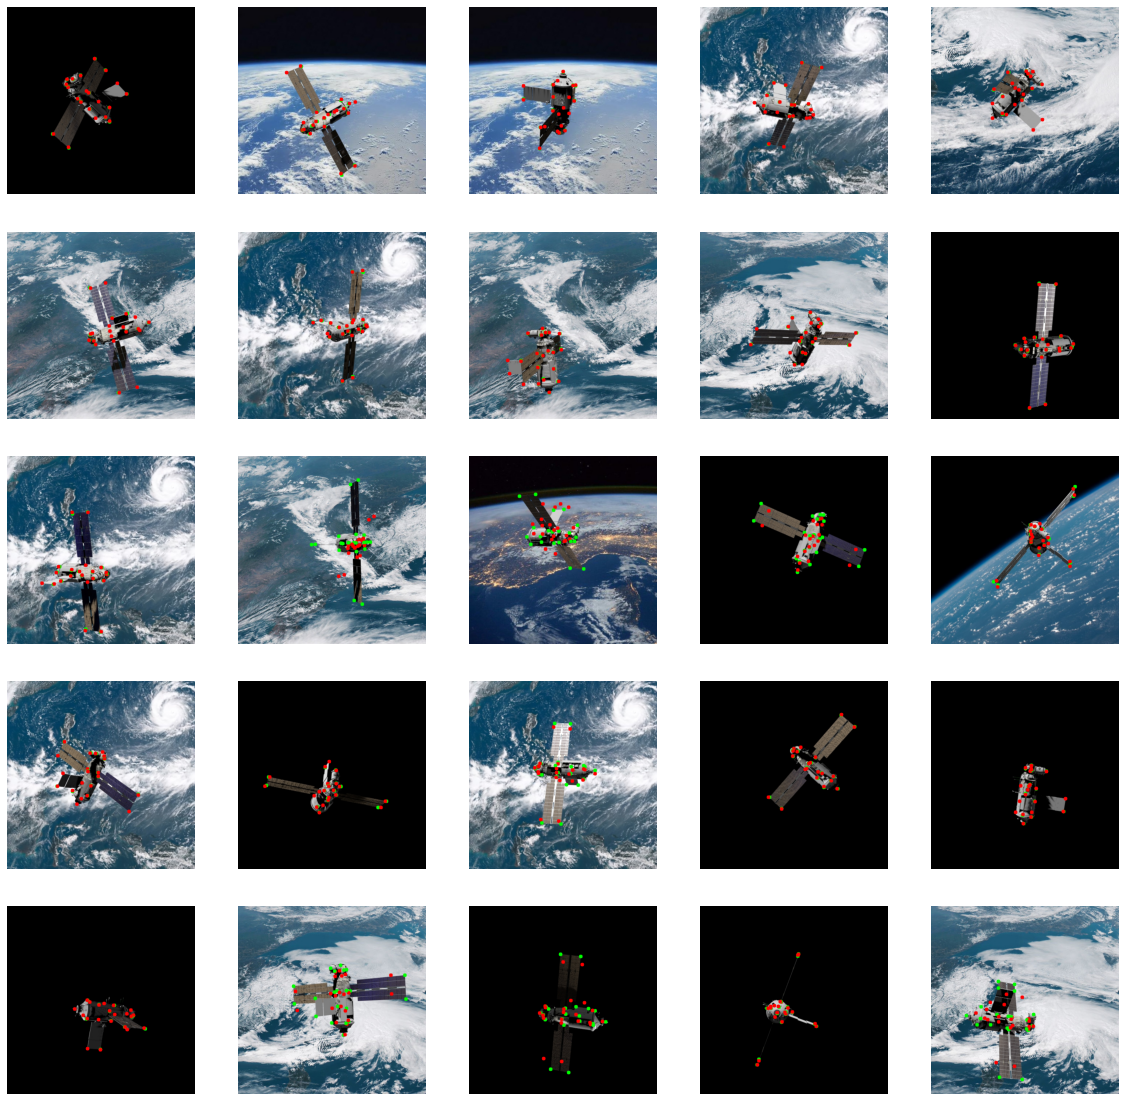

In [56]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(df), 25, replace=False)):
  img = cv2.imread('/content/images/'+df.iloc[v]['Image'])

  for j in range(21):
    img = cv2.circle(img, (int(df.iloc[v]['k'+str(j)+'x']), int(df.iloc[v]['k'+str(j)+'y'])), radius=5, color=(0, 255, 0), thickness=-1)
    img = cv2.circle(img, (int(df.iloc[v]['pk'+str(j)+'x']), int(df.iloc[v]['pk'+str(j)+'y'])), radius=5, color=(0, 0, 255), thickness=-1)
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')